#### This notebook tests the noise-corrected correlation formula on simulated crowding thresholds and reading speeds.
Created Jan 13, 2025  //  Last updated Apr 7, 2025

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm, gmean, sem, median_abs_deviation
import matplotlib.ticker as ticker
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import semopy
#import pymc as pm

In [3]:
random.seed(42)

## Functions for noise-correction

In [4]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [5]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_i, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Apply the extrapolation formula for multiple measurements (2 halves)
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

## Compute simulation parameters using pilot data

Load in crowding and RSVP pilot data so that we can compute parameters for our simulation

In [6]:
rsvp = pd.read_csv("/Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/data/df_rsvp.csv")
log_rsvp = np.log10(rsvp)

bouma_left = pd.read_csv("/Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/data/df_bouma_left.csv")
bouma_right = pd.read_csv("/Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/data/df_bouma_right.csv")
bouma = (bouma_right + bouma_left)/2
log_bouma = np.log10(bouma)
log_bouma

,0,1,2,3,4,5
0,0.004616,-0.004138,-0.508152,-0.807832,-0.641350,-0.805976
1,-0.392945,-0.435603,-0.432577,-0.394911,-0.444996,-0.453400
2,-0.438128,-0.426887,-0.352513,-0.510299,-0.392219,-0.507536
3,-0.152235,-0.383994,-0.359175,-0.149811,-0.211786,-0.228632
4,NaN,-0.468042,-0.723996,-0.821016,-0.674094,-0.497073
5,-0.589291,-0.866396,-1.043088,-0.581738,-0.383029,-0.871771
6,-0.254169,-0.497226,-0.442773,-0.661358,-0.556681,NaN
7,-0.114828,-0.159586,-0.189659,-0.197643,-0.237188,-0.212454
8,-0.697482,-0.706119,-0.647303,-0.799174,-0.515530,-0.720866
9,-0.365472,-0.285320,-0.424327,-0.355527,-0.615526,-0.544624


In [7]:
pearsonr(log_bouma.iloc[:,2], log_bouma.iloc[:,4])

PearsonRResult(statistic=np.float64(0.37908424644002736), pvalue=np.float64(0.1334533525104868))

In [8]:
pearsonr(rsvp.iloc[:,2], rsvp.iloc[:,1])

PearsonRResult(statistic=np.float64(0.7496167333827392), pvalue=np.float64(0.0005311566185937912))

In [9]:
crowding_rel = compute_noise_ceiling_splitHalf(log_bouma.iloc[:,1:3])
rsvp_rel = compute_noise_ceiling_splitHalf(rsvp.iloc[:,:2])
rel = np.sqrt(crowding_rel * rsvp_rel)
rel

np.float64(0.8660207253535982)

In [10]:
crowding_rel

np.float64(0.8366488569588125)

In [11]:
def plot_mean_thresholds(df, var_name="Bouma factor", ylims = [0.1, 0.7]):
    """
    Plots mean and median of thresholds across participants for each repeat with error bars
    
    Parameters:
    df (numpy.ndarray or pandas.DataFrame): A dataset where each column represents a different block/repeat
                                               and each row is a participant's data.
    var_name (str): The name of the variable being plotted (used in the title and y-axis label).
    """
    plt.figure(figsize=(8, 6))

    # Shaded patch
    patch_min = 0.18
    patch_max = 0.41
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)

    # X-axis positions
    x = np.arange(1, df.shape[1] + 1)

    # Compute statistics
    median_values = np.nanmedian(df, axis=0)
    mean_values = gmean(df, axis=0, nan_policy='omit')

    # Compute error bars
    median_errors = median_abs_deviation(df, axis=0, nan_policy='omit')  # MAD for median
    mean_errors = sem(df, axis=0, nan_policy='omit')  # SEM for mean

    # Plot with error bars
    plt.errorbar(x, median_values, yerr=median_errors, fmt='o-', color='orange', label='Median', capsize=0)
    plt.errorbar(x + .08, mean_values, yerr=mean_errors, fmt='o-', color='red', label='Mean', capsize=0)

    # Formatting
    plt.title(f'Mean {var_name} (N = {bouma.shape[0]})', fontsize=16)
    plt.xlabel('Repeats', fontsize=16)
    plt.xticks(x, size=14)
    plt.ylabel(var_name, fontsize=16)
    plt.legend(fontsize='large')

    # Log scale and tick formatting
    plt.yscale('log')
    plt.yticks(np.linspace(ylims[0], ylims[1], 5), size=14)
    plt.ylim(ylims)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    plt.show()

In [12]:
def plot_thresholds(df, var_name="Bouma factor", ylims = [0.08, 1.2]):
    """
    Plots thresholds for each participant across repeats.
    
    Parameters:
    df (pandas.DataFrame or numpy.ndarray): A dataset where each column represents a different repeat,
                                            and each row is a participant's data.
    var_name (str): The name of the variable being plotted (used in the title and y-axis label).
    """
    plt.figure(figsize=(8, 6))

    # Shaded patch
    patch_min = 0.18
    patch_max = 0.41
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)

    # X-axis positions
    x = np.arange(1, df.shape[1] + 1)

    # Iterate over rows properly
    for i, row in enumerate(df.values):  # Convert DataFrame to array for iteration
        plt.plot(x, row, marker='o', linestyle='-', label=f'Participant {i+1}')

    # Formatting
    plt.title(f'{var_name} (N = {df.shape[0]})', fontsize=16)
    plt.xlabel('Repeats', fontsize=16)
    plt.xticks(x, size=14)
    plt.ylabel(var_name, fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Log scale and tick formatting
    plt.yscale('log')
    plt.yticks(np.linspace(ylims[0], ylims[1], 5), size=14)
    plt.ylim(ylims)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)

    plt.show()

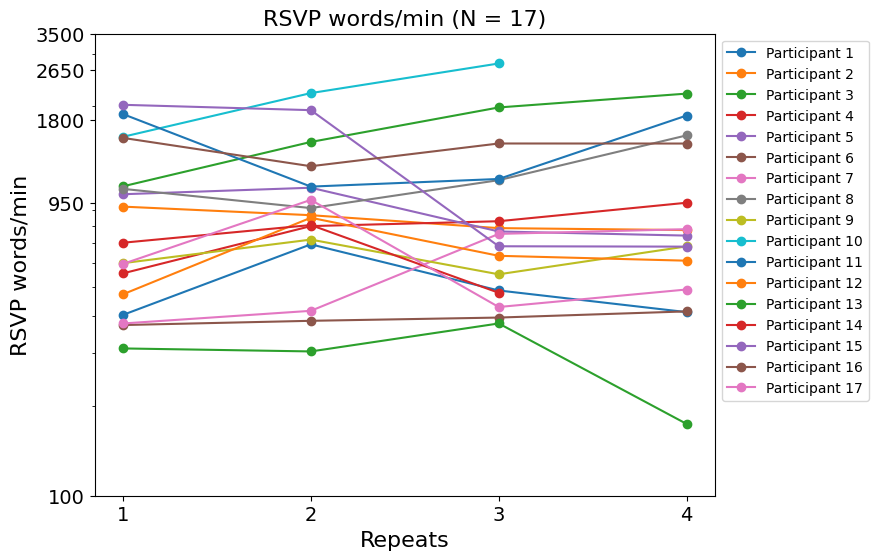

In [13]:
plot_thresholds(rsvp, var_name="RSVP words/min", ylims = [100, 3500])

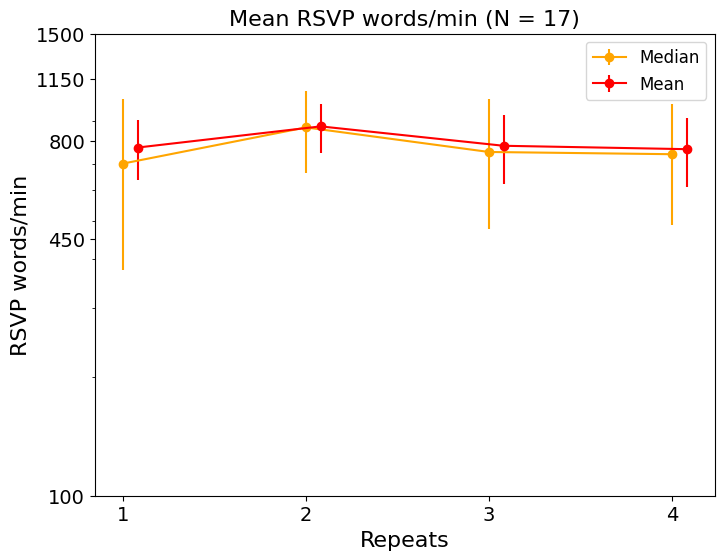

In [14]:
plot_mean_thresholds(rsvp, var_name="RSVP words/min", ylims = [100, 1500])

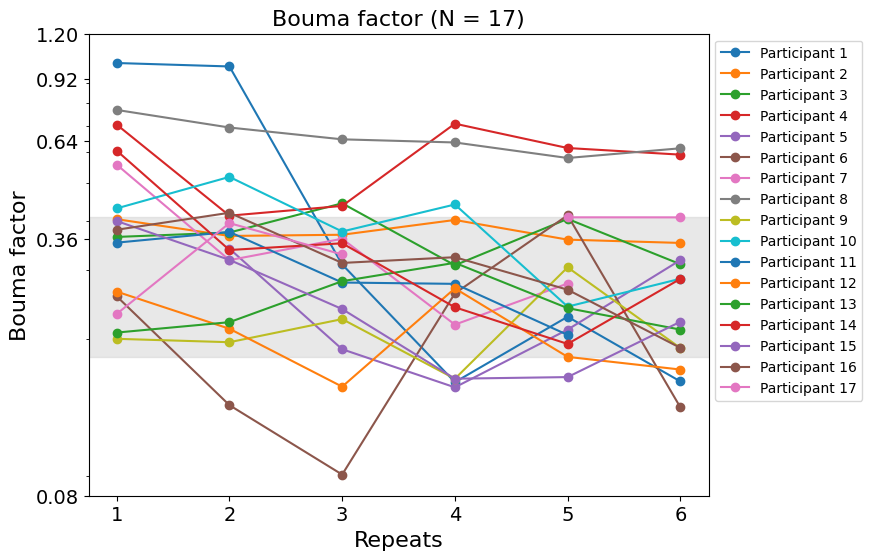

In [15]:
plot_thresholds(bouma, var_name="Bouma factor")

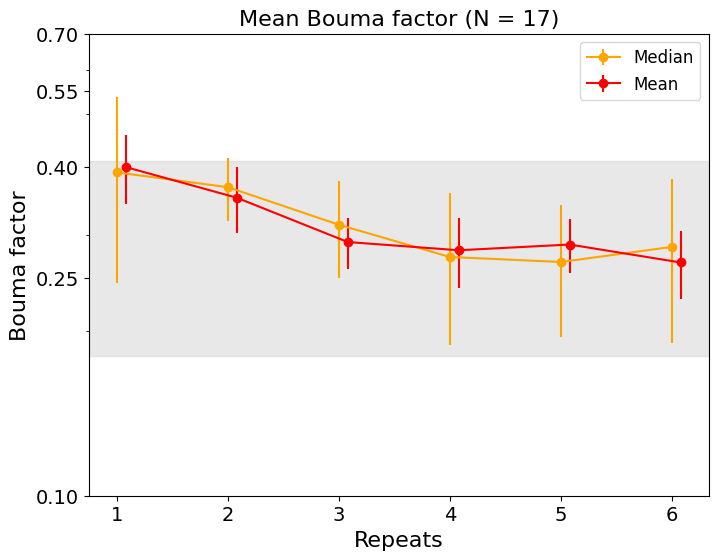

In [16]:
plot_mean_thresholds(bouma, var_name="Bouma factor", ylims = [.1, .7])

In [17]:
# print out mean values to show mean learning
bouma_mean = gmean(bouma, axis = 0, nan_policy='omit')
bouma_changes = np.array([bouma_mean[1] - bouma_mean[0], 
                          bouma_mean[2] - bouma_mean[1],
                          bouma_mean[3] - bouma_mean[2],
                          bouma_mean[4] - bouma_mean[3],
                          bouma_mean[5] - bouma_mean[4]])
print(gmean(bouma, axis = 0, nan_policy='omit').round(3))
print(bouma_changes.round(3))

[0.399 0.351 0.291 0.281 0.288 0.267]
[-0.048 -0.06  -0.01   0.007 -0.021]


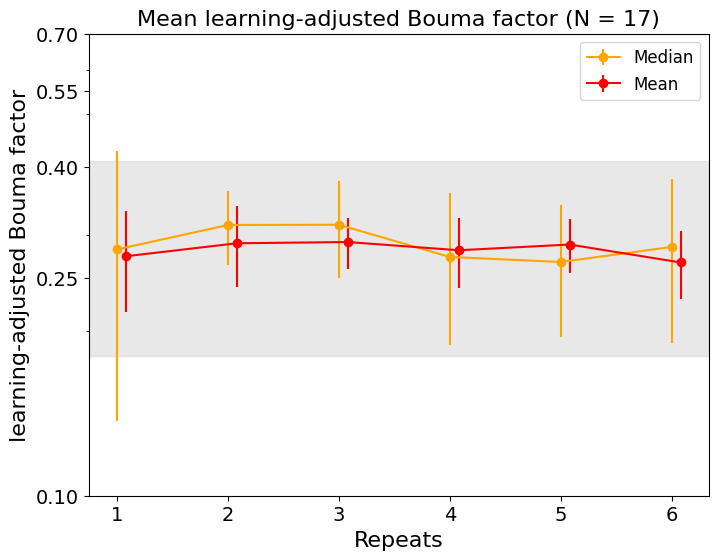

In [18]:
learning_factor_logCrowding = np.abs((bouma_changes[0] + bouma_changes[1])/2)

# Add that to our bouma array
learning_adjusted_bouma = bouma.copy()
learning_adjusted_bouma.iloc[:, 0] -= 2 * learning_factor_logCrowding
learning_adjusted_bouma.iloc[:, 1] -= learning_factor_logCrowding

plot_mean_thresholds(learning_adjusted_bouma, var_name="learning-adjusted Bouma factor")

In [19]:
log_bouma.shape

(17, 6)

In [20]:
# rsvp parameters

mean_logRSVP = np.log10(np.mean(gmean(rsvp, axis = 0, nan_policy='omit')))
print("mean of log:", np.round(mean_logRSVP, decimals=4))

withinVar_logRSVP, betweenVar_logRSVP = compute_variances(np.log10(rsvp))
print("within var of log:", np.round(withinVar_logRSVP, decimals=4))
print("across var of log:", np.round(betweenVar_logRSVP, decimals=4))

mean of log: 2.9005
within var of log: 0.0157
across var of log: 0.0558


In [21]:
# crowding parameters, learning-adjusted

mean_logCrowding = np.log10(np.mean(gmean(bouma, axis = 0, nan_policy='omit')))
print("mean of log:", np.round(mean_logCrowding, decimals=4))

withinVar_logCrowding, betweenVar_logCrowding = compute_variances(np.log10(learning_adjusted_bouma))
print("within var of log:", np.round(withinVar_logCrowding, decimals=4))
print("across var of log:", np.round(betweenVar_logCrowding, decimals=4))

mean of log: -0.5046
within var of log: 0.0255
across var of log: 0.0262


In [22]:
# crowding parameters, without first two blocks

mean_crowding_original = np.mean(gmean(bouma.iloc[:,2:], axis = 0, nan_policy='omit'))
print("mean:", np.round(mean_crowding_original, decimals=4))

withinVar_logCrowding_original, betweenVar_logCrowding_original = compute_variances(log_bouma.iloc[:,2:])
print("within var of log:", np.round(withinVar_logCrowding_original, decimals=4))
print("across var of log:", np.round(betweenVar_logCrowding_original, decimals=4))

mean: 0.2819
within var of log: 0.0141
across var of log: 0.0254


## Functions for simulations

In [23]:
class def_variable_parameters:
    
    def __init__(self, betweenVar, withinVar, mean, learning_factor):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean
        self.learning_factor = learning_factor

In [24]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = 0.6):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Increase initial crowding thresholds by learning factor (since learning hasn't yet occurred)
        if i == 0:
            crowding_measurement += 2 * crowding_params.learning_factor
        if i == 1:
            crowding_measurement += crowding_params.learning_factor

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [25]:
def make_model_spec(n_meas):
    crowding_factor = "crowding_latent =~ " + " + ".join([f"crowding_measurement{i+1}" for i in range(n_meas)])
    rsvp_factor      = "rsvp_latent =~ " + " + ".join([f"rsvp_measurement{i+1}" for i in range(n_meas)])
    correlation_line = "crowding_latent ~~ rsvp_latent"
    return "\n".join([crowding_factor, rsvp_factor, correlation_line])

In [26]:
def compute_noise_ceiling(measurements: pd.DataFrame) -> float:
    """
    measurements: DataFrame of shape (n_observers, n_repeats),
                  each column is one repeated threshold per observer.
    Returns the reliability R = Var(means) / [Var(means) + Var_within/k].
    """
    k = measurements.shape[1]
    # between‑observer variance of the k‑repeat means
    means = measurements.mean(axis=1)
    between_var = means.var(ddof=1)
    # average within‑observer variance
    within_var = measurements.var(axis=1, ddof=1).mean()
    # reliability of the mean of k repeats
    return between_var / (between_var + within_var / k)

In [27]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160, 320),
                   range_measurements=(2, 4, 8),
                   n_repetitions=500,
                   true_correlation=0.6):

    # ------------- containers ----------------------------------------
    hist_measured_corr, hist_rceiling_corr = {}, {}
    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_measured, list_rceiling = [], []
            model_spec = make_model_spec(n_meas) 

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(crowding_param, rsvp_param, n_samples, n_meas,
                                                  correlation=true_correlation)
                wMeans = sim['crowding_measurement']
                zMeans = sim['rsvp_measurement']

                # 2) --- raw correlation & noise ceiling --------------
                measured_corr, _ = pearsonr(wMeans, zMeans)

                W = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                Z = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                Rxx = compute_noise_ceiling(W)
                Ryy = compute_noise_ceiling(Z)
                lam = np.sqrt(Rxx * Ryy)

                rceiling_corr = measured_corr / lam
                
                # 3) --- stash ---------------------------------------
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)

            # ----- save full histograms ------------------------------
            hist_measured_corr[(n_samples, n_meas)] = list_measured
            hist_rceiling_corr[(n_samples, n_meas)] = list_rceiling

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "mean_measured":    np.mean(list_measured),
                "rmse_measured":    rmse(list_measured),
                "sd_measured":      np.std(list_measured),

                "mean_rceiling":    np.mean(list_rceiling),
                "rmse_rceiling":    rmse(list_rceiling),
                "sd_rceiling":      np.std(list_rceiling)
            })

        print(f"done with n_samples = {n_samples}")

    return (pd.DataFrame(results_corr),
            hist_measured_corr,
            hist_rceiling_corr)

## Functions for plotting the results

In [28]:
def plot_measured_rceiling_mmse(results_corr_df, 
                               x_values, x_subset_name,
                               line_values, line_subset_name, line_label,
                               y_measured_name, y_rceiling_name, #y_mmse_name,
                               x_label, y_label, colors,
                               y_lim=(-0.02, 0.25), true_correlation=0.6):
    """
    Plots three correlation metrics:
      - y_measured_name:   "Measured" (uncorrected)
      - y_rceiling_name:   "R-ceiling" corrected
      - y_mmse_name:        "mmse" latent correlation

    :param results_corr_df:   DataFrame containing the data to plot
    :param x_values:          Distinct x-values (e.g. [2,4,8,16])
    :param x_subset_name:     Column name in df that matches x_values (e.g. 'n_measurements')
    :param line_values:       Distinct line values (e.g. sample sizes) for the plot
    :param line_subset_name:  Column name that matches line_values (e.g. 'n_samples')
    :param line_label:        Label for the legend title (e.g. 'Sample size')
    :param y_measured_name:   Column name for measured correlation metric
    :param y_rceiling_name:   Column name for r-ceiling correlation metric
    :param y_mmse_name:        Column name for mmse correlation metric
    :param x_label:           X-axis label
    :param y_label:           Y-axis label
    :param colors:            List/array of colors for each line
    :param y_lim:             Tuple specifying y-limit on the y-axis
    """

    plt.figure(figsize=(10, 6))

    for i, lv in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == lv]
        color  = colors[i]

        x = subset[x_subset_name].to_numpy()       
        y_meas = subset[y_measured_name].to_numpy()
        y_rc   = subset[y_rceiling_name].to_numpy()
        #y_mmse  = subset[y_mmse_name].to_numpy()

        plt.plot(x, y_meas, '-o',  color=color, label=f"{lv} (Raw)")
        plt.plot(x, y_rc,   '--o', color=color, label=f"{lv} (Unbiased)")
        #plt.plot(x, y_mmse,  '-.o', color=color, label=f"{lv} (mmse)")

    # Optional reference line
    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.axhline(true_correlation, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(y_lim)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Build unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    #plt.legend(unique_handles, unique_labels, title=line_label,
     #          bbox_to_anchor=(1.05, 1), loc='upper left',
      #         title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [29]:
def plot_measured_rceiling_mmse(results_corr_df, 
                               x_values, x_subset_name,
                               line_values, line_subset_name, line_label,
                               y_measured_name, y_rceiling_name, #y_mmse_name,
                               x_label, y_label, colors,
                               y_lim=(-0.02, 0.25), true_correlation=0.6):
    """
    Plots three correlation metrics:
      - y_measured_name:   "Measured" (uncorrected)
      - y_rceiling_name:   "R-ceiling" corrected
      - y_mmse_name:        "mmse" latent correlation

    :param results_corr_df:   DataFrame containing the data to plot
    :param x_values:          Distinct x-values (e.g. [2,4,8,16])
    :param x_subset_name:     Column name in df that matches x_values (e.g. 'n_measurements')
    :param line_values:       Distinct line values (e.g. sample sizes) for the plot
    :param line_subset_name:  Column name that matches line_values (e.g. 'n_samples')
    :param line_label:        Label for the legend title (e.g. 'Sample size')
    :param y_measured_name:   Column name for measured correlation metric
    :param y_rceiling_name:   Column name for r-ceiling correlation metric
    :param y_mmse_name:        Column name for mmse correlation metric
    :param x_label:           X-axis label
    :param y_label:           Y-axis label
    :param colors:            List/array of colors for each line
    :param y_lim:             Tuple specifying y-limit on the y-axis
    """

    plt.figure(figsize=(10, 6))

    x = results_corr_df[x_subset_name].to_numpy()       
    y_meas = results_corr_df[y_measured_name].to_numpy()
    y_rc   = results_corr_df[y_rceiling_name].to_numpy()

    plt.plot(x, y_meas, '-o',  label="Naive")
    plt.plot(x, y_rc,   '--o', label="Corrected")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    #plt.axhline(true_correlation, color='gray', linestyle='dashed', linewidth=1)
    #plt.ylim(y_lim)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.legend(title=line_label)

    plt.tight_layout()
    plt.show()

In [30]:
def plot_sim_results(results_corr_df, true_correlation=0.6):

    sample_sizes = sorted(results_corr_df["n_samples"].unique())
    colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))
    n_measurements = sorted(results_corr_df["n_measurements"].unique())

    # 1) RMSE
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=sample_sizes,
        x_subset_name='n_samples',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Correlation estimator',
        y_measured_name='rmse_measured',
        y_rceiling_name='rmse_rceiling',
        #y_mmse_name='rmse_mmse_corr',
        x_label='Sample size',
        y_label='RMSE',
        colors=colors,
        y_lim=(-0.02, 0.25),
        true_correlation=true_correlation
    )

    # 2) Mean difference
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=n_measurements,
        x_subset_name='n_measurements',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Sample size',
        y_measured_name='mean_measured',
        y_rceiling_name='mean_rceiling',
        #y_mmse_name='mean_mmse_corr',
        x_label='Number of measurements',
        y_label='Mean',
        colors=colors,
        y_lim=(true_correlation-.2, true_correlation+.2),
        true_correlation=true_correlation
    )

    # 3) Standard Deviation
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=n_measurements,
        x_subset_name='n_measurements',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Sample size',
        y_measured_name='sd_measured',
        y_rceiling_name='sd_rceiling',
       # y_mmse_name='sd_mmse_corr',
        x_label='Number of measurements',
        y_label='SD',
        colors=colors,
        y_lim=(-0.02, 0.25),
        true_correlation=true_correlation
    )

In [31]:
def plot_histograms(hist_corr, corr_type="Uncorrected"):
    """
    Plots histograms of differences in correlation values for different sample and measurement conditions.
    
    Parameters:
    hist_corr (dict): A dictionary where keys are tuples (n_samples, n_measurements),
                      and values are lists/arrays of differences.
    corr_type (str): either "Uncorrected" or "Corrected"
    """
    for (n_samples, n_measurements), differences in hist_corr.items():
        mean_diff = np.mean(differences)
        sd = np.std(differences)

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.hist(differences, bins=20, alpha=0.7, edgecolor='black')

        # Add vertical lines for mean and standard deviation
        ax.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2)
        ax.axvline(0.6, color='black', linestyle='dashed', linewidth=3)

        # Text relative to axis coordinates (0 to 1 range)
        ax.text(0.69, 0.92, 'ground truth', transform=ax.transAxes, fontsize=11, color='black')
        ax.text(mean_diff-.07, 0.92, 'mean', transform=ax.transAxes, fontsize=11, color='red')

        # Formatting
        ax.set_xlim(-0.2, 1)
        ax.set_ylim(0, 190)
        ax.set_xlabel(f"{corr_type}-Sample R")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Samples={n_samples}, Measurements={n_measurements}")
        plt.tight_layout()
        plt.show()

        print(f"Mean difference: {0.6-mean_diff:.3f}")

In [32]:
crowding_param = def_variable_parameters(betweenVar = betweenVar_logCrowding_original, 
                                         withinVar = withinVar_logCrowding_original, 
                                         mean = mean_logCrowding, 
                                         learning_factor = 0)

rsvp_param = def_variable_parameters(betweenVar = betweenVar_logRSVP, 
                                     withinVar = withinVar_logRSVP, 
                                     mean = mean_logRSVP, 
                                     learning_factor = 0)

In [33]:
# Run simulation
results_corr_df, hist_measured_corr, hist_ceiling_corr = run_simulation(crowding_param, rsvp_param,
                   range_samples=(10, 20, 40, 80, 160, 320),
                   range_measurements=([2]),
                   n_repetitions=1000,
                   true_correlation=0.6)

done with n_samples = 10
done with n_samples = 20
done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


In [34]:
results_corr_df

,n_samples,n_measurements,mean_measured,rmse_measured,sd_measured,mean_rceiling,rmse_rceiling,sd_rceiling
0,10,2,0.479836,0.293390,0.267653,0.572876,0.323060,0.321919
1,20,2,0.483592,0.212541,0.177829,0.570250,0.208113,0.205975
2,40,2,0.493725,0.163368,0.124075,0.579386,0.142608,0.141111
3,80,2,0.493680,0.137054,0.086485,0.578334,0.100953,0.098600
4,160,2,0.495025,0.120985,0.060147,0.579436,0.070757,0.067702
5,320,2,0.497175,0.110956,0.041693,0.581783,0.050545,0.047149


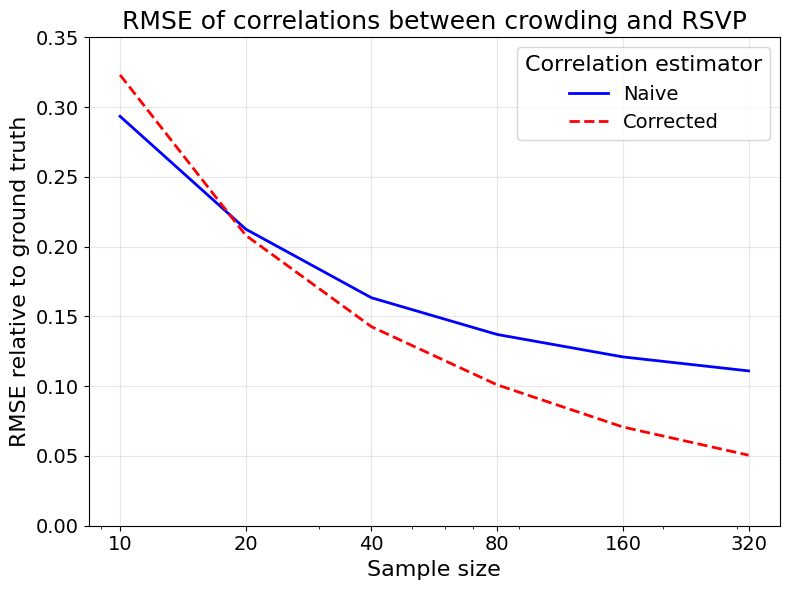

In [36]:
plt.figure(figsize=(8, 6))

plt.plot(results_corr_df.n_samples, results_corr_df.rmse_measured, 'b-', linewidth=2, label='Naive')
plt.plot(results_corr_df.n_samples, results_corr_df.rmse_rceiling, 'r--', linewidth=2, label='Corrected')

plt.xlabel('Sample size', fontsize=16)
plt.ylabel('RMSE relative to ground truth', fontsize=16)
plt.title('RMSE of correlations between crowding and RSVP', fontsize=18)
plt.legend(title='Correlation estimator', fontsize=14, title_fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,0.35)

plt.xscale('log')
plt.xticks(results_corr_df.n_samples, results_corr_df.n_samples)  # Show actual values on x-axis

plt.tight_layout()
plt.show()

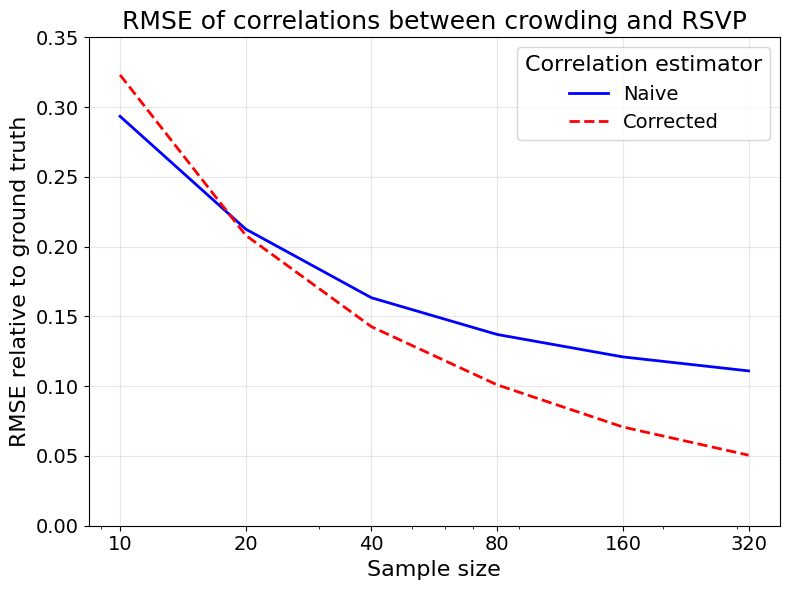

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(results_corr_df.n_samples, results_corr_df.r_measured, 'b-', linewidth=2, label='Naive')
plt.plot(results_corr_df.n_samples, results_corr_df.r_corrected, 'r--', linewidth=2, label='Corrected')

plt.xlabel('Sample size', fontsize=16)
plt.ylabel('RMSE relative to ground truth', fontsize=16)
plt.title('RMSE of correlations between crowding and RSVP', fontsize=18)
plt.legend(title='Correlation estimator', fontsize=14, title_fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,0.35)

plt.xscale('log')
plt.xticks(results_corr_df.n_samples, results_corr_df.n_samples)  # Show actual values on x-axis

plt.tight_layout()
plt.show()

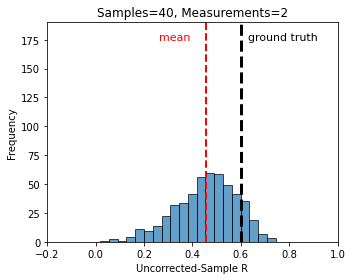

Mean difference: 0.144


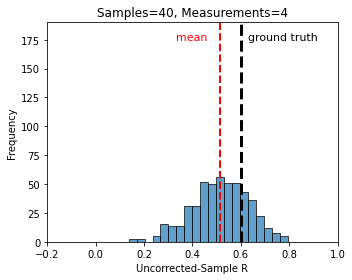

Mean difference: 0.086


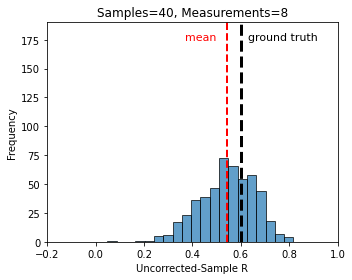

Mean difference: 0.057


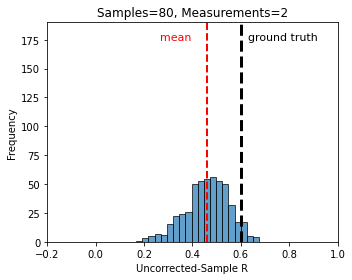

Mean difference: 0.141


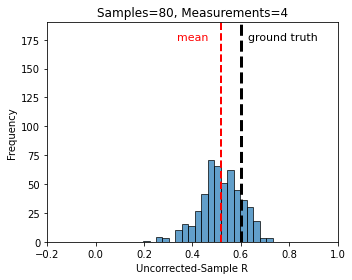

Mean difference: 0.083


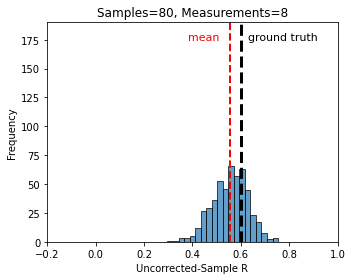

Mean difference: 0.045


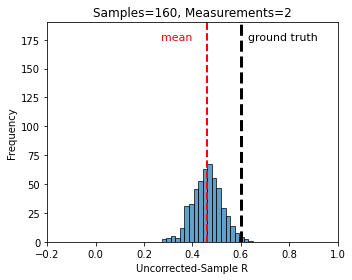

Mean difference: 0.140


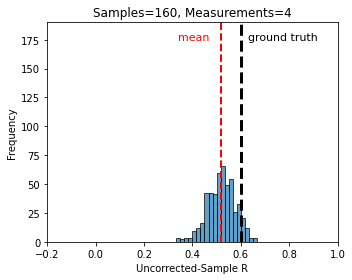

Mean difference: 0.081


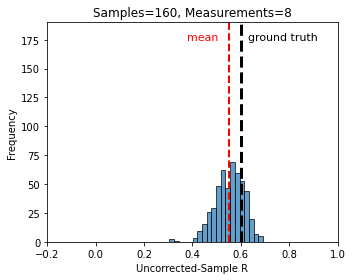

Mean difference: 0.047


In [138]:
plot_histograms(hist_measured_corr, corr_type = "Uncorrected")

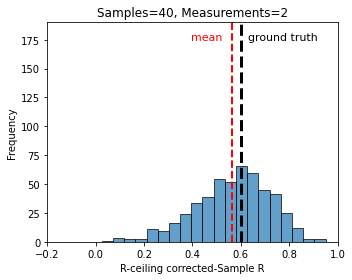

Mean difference: 0.035


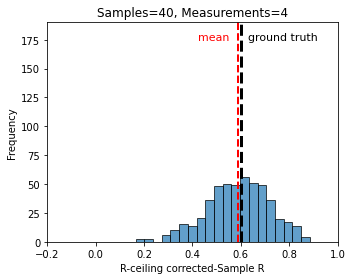

Mean difference: 0.013


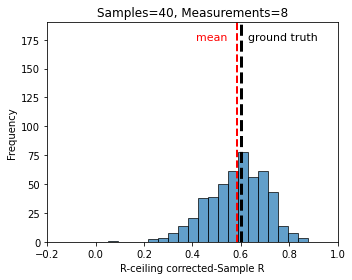

Mean difference: 0.016


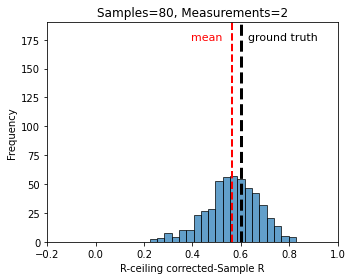

Mean difference: 0.036


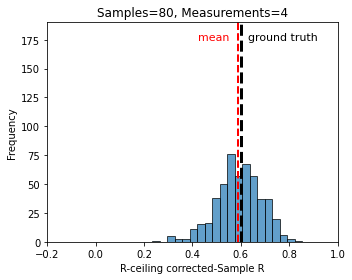

Mean difference: 0.010


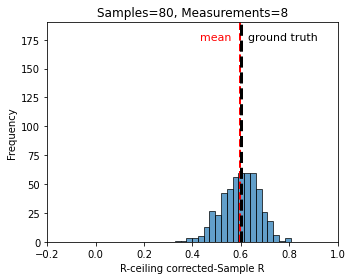

Mean difference: 0.003


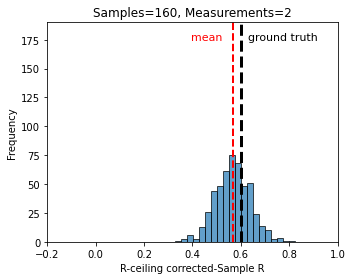

Mean difference: 0.033


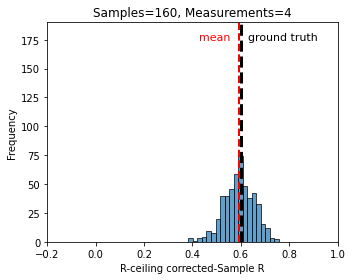

Mean difference: 0.009


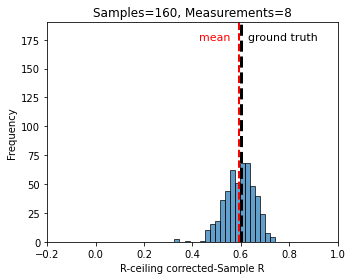

Mean difference: 0.006


In [139]:
plot_histograms(hist_ceiling_corr, corr_type = "R-ceiling corrected")

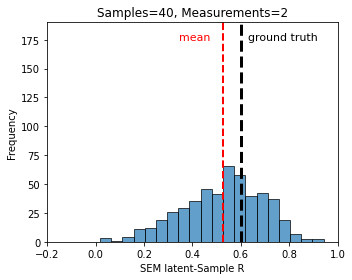

Mean difference: 0.075


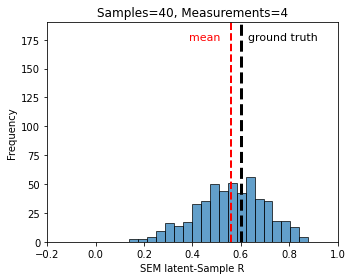

Mean difference: 0.042


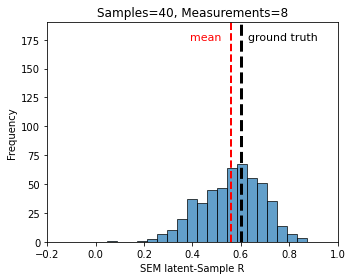

Mean difference: 0.039


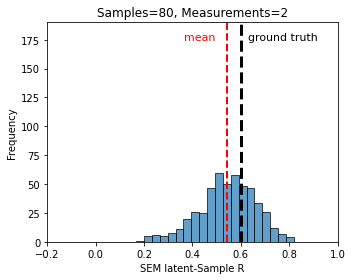

Mean difference: 0.057


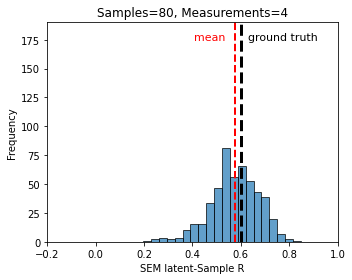

Mean difference: 0.025


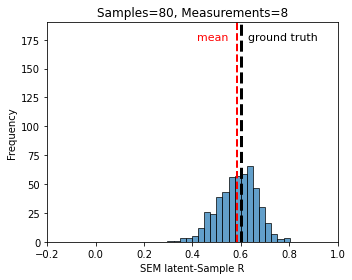

Mean difference: 0.015


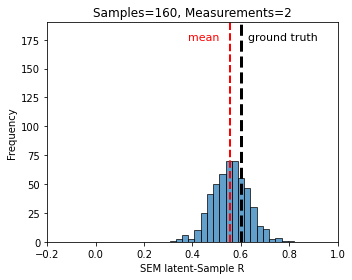

Mean difference: 0.044


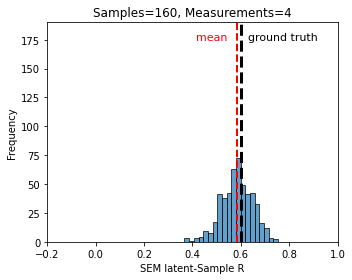

Mean difference: 0.016


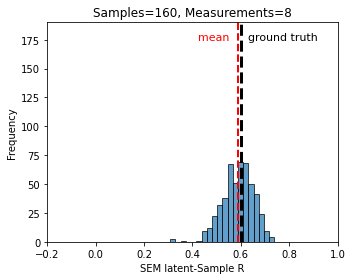

Mean difference: 0.012


In [140]:
plot_histograms(hist_mmse_corr, corr_type = "SEM latent")

## mean-variance

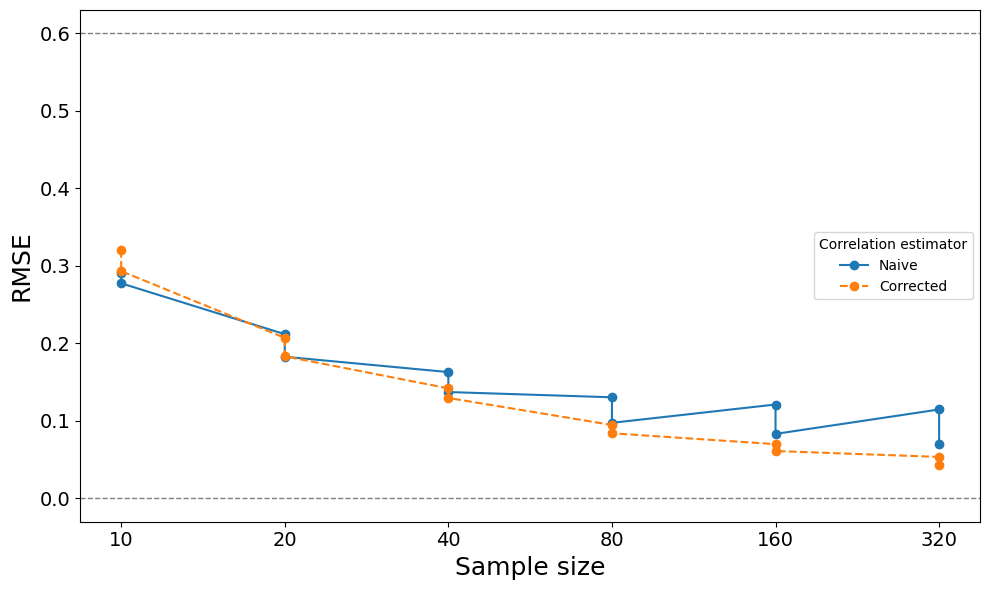

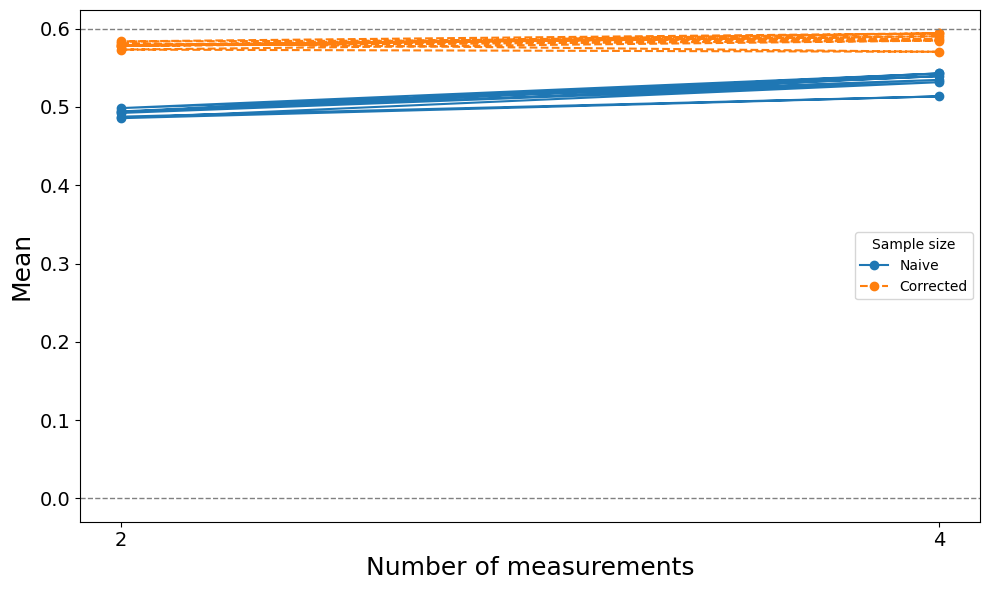

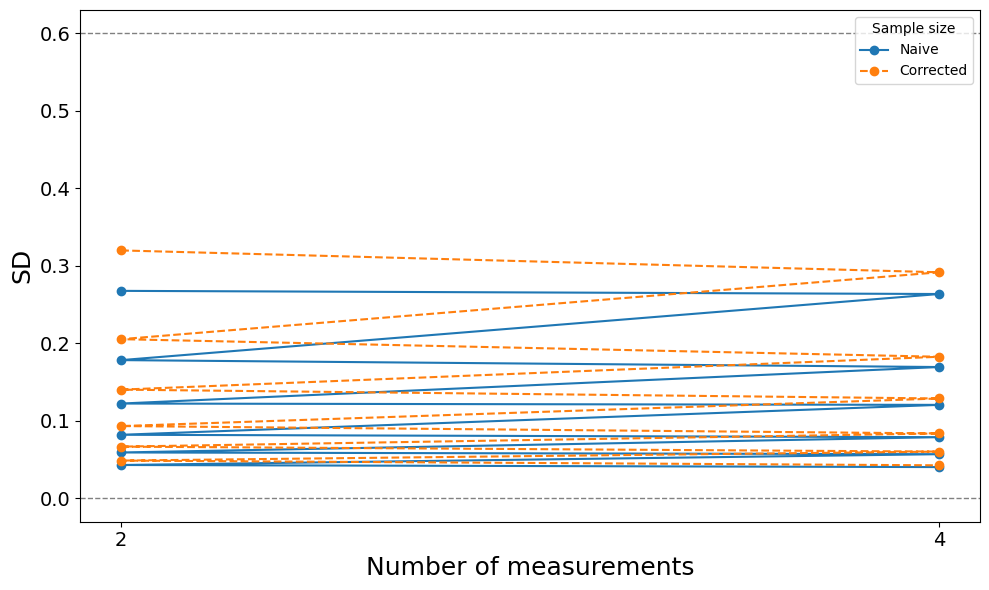

In [51]:
plot_sim_results(results_corr_df, true_correlation=0.6)

# ARCHIVE

In [ ]:
# ---- MMSE performance very comparable to or worse than R ceiling -------

def run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160, 320),
                   range_measurements=(2, 4, 8),
                   n_repetitions=500,
                   true_correlation=0.6):

    # ------------- containers ----------------------------------------
    hist_measured_corr, hist_rceiling_corr, hist_mmse_corr = {}, {}, {}
    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_measured, list_rceiling, list_mmse = [], [], []
            model_spec = make_model_spec(n_meas) 

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(crowding_param, rsvp_param, n_samples, n_meas,
                                                  correlation=true_correlation)
                wMeans = sim['crowding_measurement']
                zMeans = sim['rsvp_measurement']

                # 2) --- raw correlation & noise ceiling --------------
                measured_corr, _ = pearsonr(wMeans, zMeans)

                W = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                Z = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                Rxx = compute_noise_ceiling(W)
                Ryy = compute_noise_ceiling(Z)
                lam = np.sqrt(Rxx * Ryy)

                rceiling_corr = measured_corr / lam

                # 3) --- MMSE correlation -------------------
                # Take vars of means
                wMeans = np.mean(W, axis=1)
                wVarMean = np.var(wMeans) 

                zMeans = np.mean(Z, axis=1)
                zVarMean = np.var(zMeans)

                # an estimate of Cov(W,Z). wzCov is approx. = Cov(X,Y)
                wzCov = np.cov(wMeans,zMeans)[0,1] 

                # Take means of vars, remembering to use ddof=1 (I forgot this before)
                eVarW = np.mean(np.var(W,axis=1, ddof=1)) 
                eVarZ = np.mean(np.var(Z,axis=1, ddof=1))
                
                # we expect wVarMean to be approx Var(X) + Var(e)/m, so we can subtract Var(e)/m off from wVarMean
                mmse_corr = wzCov / np.sqrt((wVarMean - eVarW/n_meas) * (zVarMean - eVarZ/n_meas))
                
                # 4) --- stash ---------------------------------------
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)
                list_mmse.append(mmse_corr)

            # ----- save full histograms ------------------------------
            hist_measured_corr[(n_samples, n_meas)] = list_measured
            hist_rceiling_corr[(n_samples, n_meas)] = list_rceiling
            hist_mmse_corr[(n_samples, n_meas)]    = list_mmse

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "mean_measured":    np.mean(list_measured),
                "rmse_measured":    rmse(list_measured),
                "sd_measured":      np.std(list_measured),

                "mean_rceiling":    np.mean(list_rceiling),
                "rmse_rceiling":    rmse(list_rceiling),
                "sd_rceiling":      np.std(list_rceiling),

                "mean_mmse_corr":   np.mean(list_mmse),
                "rmse_mmse_corr":   rmse(list_mmse),
                "sd_mmse_corr":     np.std(list_mmse)
            })

        print(f"done with n_samples = {n_samples}")

    return (pd.DataFrame(results_corr),
            hist_measured_corr,
            hist_rceiling_corr,
            hist_mmse_corr)

In [ ]:
#----- INCLUDES BLENDED, OPTIMAL ALPHA METHOD -------
#----- PERFORMANCE IS GENERALLY WORSE THAN NOISE-CEILING CORRECTION BC ALPHA-OPT IS NOISIER -------

# ---------------------------------------------------------------------
#  Helpers for the MMSE estimator
# ---------------------------------------------------------------------

def compute_noise_ceiling(measurements: pd.DataFrame) -> float:
    """
    measurements: DataFrame of shape (n_observers, n_repeats),
                  each column is one repeated threshold per observer.
    Returns the reliability R = Var(means) / [Var(means) + Var_within/k].
    """
    k = measurements.shape[1]
    # between‑observer variance of the k‑repeat means
    means = measurements.mean(axis=1)
    between_var = means.var(ddof=1)
    # average within‑observer variance
    within_var = measurements.var(axis=1, ddof=1).mean()
    # reliability of the mean of k repeats
    return between_var / (between_var + within_var / k)


def mmse_blend_iterative(r_raw, lam, N, n_iter=5):
    """
    Iteratively refine alpha and rho. 
      r_raw: observed raw correlation
      lam:   noise ceiling factor
      N:     sample size
      n_iter: how many refine steps to do
    """
    # 1) initialize rho_hat = bias-corrected estimate
    rho_hat = r_raw / lam
    
    # 2) precompute sampling variance of r_raw
    sig2 = (1 - r_raw**2)**2 / (N - 1)
    
    for _ in range(n_iter):
        # compute optimal alpha given current rho_hat
        alpha = sig2 / ((1 - lam)*(sig2 + lam**2 * rho_hat**2))
        alpha = np.clip(alpha, 0, 1)
        
        # update our estimate of rho
        rho_hat = alpha * r_raw + (1 - alpha) * (r_raw / lam)
    
    # final blended correlation
    blended = rho_hat
    return blended, alpha
# ---------------------------------------------------------------------

def run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160),
                   range_measurements=(2, 4, 8),
                   n_repetitions=500,
                   true_correlation=0.6):

    # ------------- containers ----------------------------------------
    hist_measured_corr, hist_rceiling_corr, hist_mmse_corr = {}, {}, {}
    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_measured, list_rceiling, list_mmse = [], [], []
            model_spec = make_model_spec(n_meas) 

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(crowding_param, rsvp_param, n_samples, n_meas,
                                                  correlation=true_correlation)

                # 2) --- raw correlation & noise ceiling --------------
                measured_corr, _ = pearsonr(
                    sim['crowding_measurement'],
                    sim['rsvp_measurement']
                )

                crowding_meas = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_meas     = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                Rxx = compute_noise_ceiling(crowding_meas)
                Ryy = compute_noise_ceiling(rsvp_meas)
                lam = np.sqrt(Rxx * Ryy)

                rceiling_corr = measured_corr / lam

                # 3) --- blended (MMSE) correlation -------------------
                mmse_corr, final_alpha = mmse_blend_iterative(
                    r_raw=measured_corr,
                    lam=lam,
                    N=n_samples
                )
                
                # 4) --- stash ---------------------------------------
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)
                list_mmse.append(mmse_corr)

            # ----- save full histograms ------------------------------
            hist_measured_corr[(n_samples, n_meas)] = list_measured
            hist_rceiling_corr[(n_samples, n_meas)] = list_rceiling
            hist_mmse_corr[(n_samples, n_meas)]    = list_mmse

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "mean_measured":    np.mean(list_measured),
                "rmse_measured":    rmse(list_measured),
                "sd_measured":      np.std(list_measured),

                "mean_rceiling":    np.mean(list_rceiling),
                "rmse_rceiling":    rmse(list_rceiling),
                "sd_rceiling":      np.std(list_rceiling),

                "mean_mmse_corr":   np.mean(list_mmse),
                "rmse_mmse_corr":   rmse(list_mmse),
                "sd_mmse_corr":     np.std(list_mmse)
            })

        print(f"done with n_samples = {n_samples}")

    return (pd.DataFrame(results_corr),
            hist_measured_corr,
            hist_rceiling_corr,
            hist_mmse_corr)


In [96]:
#----- INCLUDES SEM METHOD -------
#----- SEM PERFORMANCE IS NEARLY IDENTICAL TO NOISE-CEILING CORRECTION -------

def run_simulation(crowding_param, rsvp_param, 
                   range_samples=[40, 80, 160, 320],
                   range_measurements=[2, 4, 8], 
                   n_repetitions=500, 
                   true_correlation=0.6):   

    # Store distributions from each iteration
    hist_measured_corr, hist_rceiling_corr, hist_sem_corr = {}, {}, {}
    
    # Store final results (aggregated stats)
    results_corr = []

    for n_samples in range_samples:
        for n_meas in range_measurements:
            list_measured, list_rceiling, list_sem = [], [], []

            # Build the semopy model spec for the current n_meas
            model_spec = make_model_spec(n_meas)

            for _ in range(n_repetitions):
                # 1) Simulate data
                simulation_data = simulate_psychophysics_data(
                    crowding_param, rsvp_param, 
                    n_samples, n_meas,
                    correlation=true_correlation
                )
                
                # 2) Compute measured corr & r-ceiling
                measured_corr, _ = pearsonr(
                    simulation_data['crowding_measurement'],
                    simulation_data['rsvp_measurement']
                )

                crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_measurements     = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

                r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
                r_ceil_rsvp     = compute_noise_ceiling(rsvp_measurements)
                r_ceil          = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

                rceiling_corr = measured_corr / r_ceil

                # 3) Fit SEM to get latent correlation
                mod = semopy.Model(model_spec)
                mod.fit(simulation_data)
                df = mod.inspect()
                
                # Variance of crowding_latent
                var_crowd = df.loc[(df['lval'] == 'crowding_latent') & (df['op'] == '~~') & 
                                   (df['rval'] == 'crowding_latent'), 'Estimate'].values[0]

                # Variance of rsvp_latent
                var_rsvp = df.loc[(df['lval'] == 'rsvp_latent') & (df['op'] == '~~') & 
                                  (df['rval'] == 'rsvp_latent'), 'Estimate'].values[0]

                # Covariance between them
                cov_latents = df.loc[(df['lval'] == 'crowding_latent') & (df['op'] == '~~') & 
                                     (df['rval'] == 'rsvp_latent'), 'Estimate'].values[0]

                # Latent correlation = cov / sqrt(var1 * var2)
                sem_corr = cov_latents / np.sqrt(var_crowd * var_rsvp)

                # 4) Store the three correlations for this iteration
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)
                list_sem.append(sem_corr)

            # Save the full distributions
            hist_measured_corr[(n_samples, n_meas)]  = list_measured
            hist_rceiling_corr[(n_samples, n_meas)]  = list_rceiling
            hist_sem_corr[(n_samples, n_meas)]       = list_sem

            # Summaries
            rmse_measured  = np.sqrt(np.mean([(x - true_correlation)**2 for x in list_measured]))
            rmse_rceiling  = np.sqrt(np.mean([(x - true_correlation)**2 for x in list_rceiling]))
            rmse_sem       = np.sqrt(np.mean([(x - true_correlation)**2 for x in list_sem]))

            mean_measured  = np.mean(list_measured)
            mean_rceiling  = np.mean(list_rceiling)
            mean_sem       = np.mean(list_sem)

            sd_measured    = np.std(list_measured)
            sd_rceiling    = np.std(list_rceiling)
            sd_sem         = np.std(list_sem)

            # Append results
            results_corr.append({
                "n_samples":       n_samples,
                "n_measurements":  n_meas,

                "mean_measured":   mean_measured,
                "rmse_measured":   rmse_measured,
                "sd_measured":     sd_measured,

                "mean_rceiling":   mean_rceiling,
                "rmse_rceiling":   rmse_rceiling,
                "sd_rceiling":     sd_rceiling,

                "mean_sem_corr":   mean_sem,
                "rmse_sem_corr":   rmse_sem,
                "sd_sem_corr":     sd_sem
            })

        print("done with n_samples =", n_samples)

    results_corr_df = pd.DataFrame(results_corr)
    return results_corr_df, hist_measured_corr, hist_rceiling_corr, hist_sem_corr

In [107]:
#----- MMSE PERFORMANCE IS NEARLY IDENTICAL TO NOISE-CEILING CORRECTION – I THINK? -------

# ---------------------------------------------------------------------
#  Helpers for the MMSE estimator
# ---------------------------------------------------------------------
def mmse_shrinkage_alpha(r_unbiased, n):
    """
    Plug‑in alpha that minimises finite‑sample MSE for the class
        rho_hat = alpha * r_unbiased .
    Parameters
    ----------
    r_unbiased : float
        Unbiased attenuation‑corrected correlation  (could be > 1 in rare
        samples – we clip later).
    n : int
        Sample size (number of observers).
    Returns
    -------
    alpha_star : float in [0,1]
    """
    eps = 1e-10                        # avoid division by zero
    r2 = np.clip(r_unbiased**2, 0.0, 1.0 - eps)
    denom = 1.0 + ((1.0 - r2)**2) / ((n - 1.0) * (r2 + eps))
    return 1.0 / denom


def mmse_blend(r_raw, r_ceiling, n):
    """
    Compute the minimum‑MSE blended correlation.
    """
    if r_ceiling <= 0:                 # safety
        return np.nan
    r_unbiased = r_raw / r_ceiling     # classic correction for attenuation
    alpha = mmse_shrinkage_alpha(r_unbiased, n)
    return alpha * r_unbiased          # MMSE estimator
# ---------------------------------------------------------------------


def run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160),
                   range_measurements=(2, 4, 8),
                   n_repetitions=500,
                   true_correlation=0.6):

    # ------------- containers ----------------------------------------
    hist_measured_corr, hist_rceiling_corr, hist_mmse_corr = {}, {}, {}
    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_measured, list_rceiling, list_mmse = [], [], []

            model_spec = make_model_spec(n_meas)   # unchanged

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(
                    crowding_param, rsvp_param,
                    n_samples, n_meas,
                    correlation=true_correlation
                )

                # 2) --- raw correlation & noise ceiling --------------
                measured_corr, _ = pearsonr(
                    sim['crowding_measurement'],
                    sim['rsvp_measurement']
                )

                crowding_meas = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_meas     = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                r_ceil_crowd  = compute_noise_ceiling(crowding_meas)
                r_ceil_rsvp   = compute_noise_ceiling(rsvp_meas)
                r_ceil        = np.sqrt(r_ceil_crowd * r_ceil_rsvp)

                rceiling_corr = measured_corr / r_ceil

                # 3) --- blended (MMSE) correlation -------------------
                mmse_corr = mmse_blend(measured_corr, r_ceil, n_samples)

                # 4) --- stash ---------------------------------------
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)
                list_mmse.append(mmse_corr)

            # ----- save full histograms ------------------------------
            hist_measured_corr[(n_samples, n_meas)] = list_measured
            hist_rceiling_corr[(n_samples, n_meas)] = list_rceiling
            hist_mmse_corr[(n_samples, n_meas)]    = list_mmse

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "mean_measured":    np.mean(list_measured),
                "rmse_measured":    rmse(list_measured),
                "sd_measured":      np.std(list_measured),

                "mean_rceiling":    np.mean(list_rceiling),
                "rmse_rceiling":    rmse(list_rceiling),
                "sd_rceiling":      np.std(list_rceiling),

                "mean_mmse_corr":   np.mean(list_mmse),
                "rmse_mmse_corr":   rmse(list_mmse),
                "sd_mmse_corr":     np.std(list_mmse)
            })

        print(f"done with n_samples = {n_samples}")

    return (pd.DataFrame(results_corr),
            hist_measured_corr,
            hist_rceiling_corr,
            hist_mmse_corr)